In [1]:
# Import libraries
import os
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from timm import create_model
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import seaborn as sns

In [2]:
# Configure device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [3]:
# Define data directory
data_dir = "./data"  

# Transform data
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [4]:
# Load datasets
train_data = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_train)
val_data   = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_test)
test_data  = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform_test)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=32, shuffle=False)

class_names = train_data.classes
print("Classes:", class_names)

Classes: ['fire', 'nofire']


In [5]:
# Load pretrained ViT
from timm import create_model
model = create_model('vit_tiny_patch16_224', pretrained=True, num_classes=2)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [6]:
# Training function
def train(model, loader):
    model.train()
    total_loss = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [7]:
# Evaluation function
def evaluate(model, loader, title="Validation"):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu()
            all_preds.extend(preds)
            all_labels.extend(labels)
    print(f"📈 {title} Results")
    print(classification_report(all_labels, all_preds, target_names=class_names))

In [8]:
# Freeze all except classifier
for param in model.parameters():
    param.requires_grad = False
for param in model.head.parameters():
    param.requires_grad = True

# Training loop
for epoch in range(3):
    loss = train(model, train_loader)
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}")

evaluate(model, val_loader)

# Save
torch.save(model.state_dict(), 'vit_forest_fire.pth')

Epoch 1, Loss: 0.5560
Epoch 2, Loss: 0.3570
Epoch 3, Loss: 0.2921
📈 Validation Results
              precision    recall  f1-score   support

        fire       0.93      0.97      0.95       250
      nofire       0.96      0.91      0.94       191

    accuracy                           0.95       441
   macro avg       0.95      0.94      0.94       441
weighted avg       0.95      0.95      0.95       441



In [9]:
# Test accuracy 
def test_accuracy(model, test_loader):
    model.eval()
    all_preds, all_labels = [] , []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    print(f"✅ Test Accuracy: {acc * 100:.2f}%")
    return acc
    
test_accuracy(model, test_loader)

✅ Test Accuracy: 94.14%


0.9414414414414415

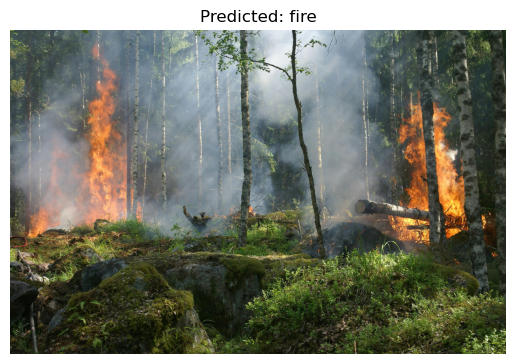

In [10]:
# Recreate model for inference
model = create_model('vit_tiny_patch16_224', pretrained=False, num_classes=2)
model.load_state_dict(torch.load('vit_forest_fire.pth', map_location=device))
model = model.to(device)
model.eval()

# Inference on a Single Image 
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load a sample image from val set 
img_path = 'data/val/pexels-pixabay-51951.jpg' 
img = Image.open(img_path).convert('RGB')
input_tensor = transform(img).unsqueeze(0).to(device)

# Inference
with torch.no_grad():
    output = model(input_tensor)
    predicted = torch.argmax(output, dim=1).item()

# Decode prediction
label = class_names[predicted]
# Show image with prediction
plt.imshow(img)
plt.title(f"Predicted: {label}")
plt.axis('off')
plt.show()

Confusion Matrix:
 [[247   5]
 [ 21 171]]


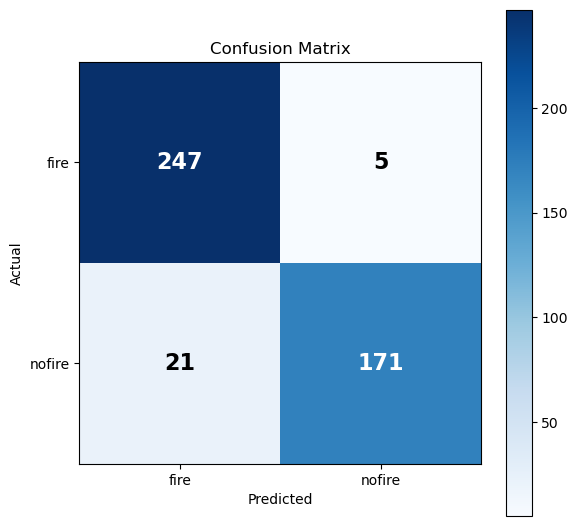

In [11]:
# Confusion Matrix visualization
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:  
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=16, fontweight='bold')

# Axis labels and title 
ax.set(xticks=np.arange(len(class_names)),
       yticks=np.arange(len(class_names)),
       xticklabels=class_names,
       yticklabels=class_names,
       ylabel='Actual',
       xlabel='Predicted',
       title='Confusion Matrix')

plt.tight_layout()
plt.colorbar(im)
plt.show()

In [12]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from timm import create_model
from torchvision import transforms
import torch.nn.functional as F

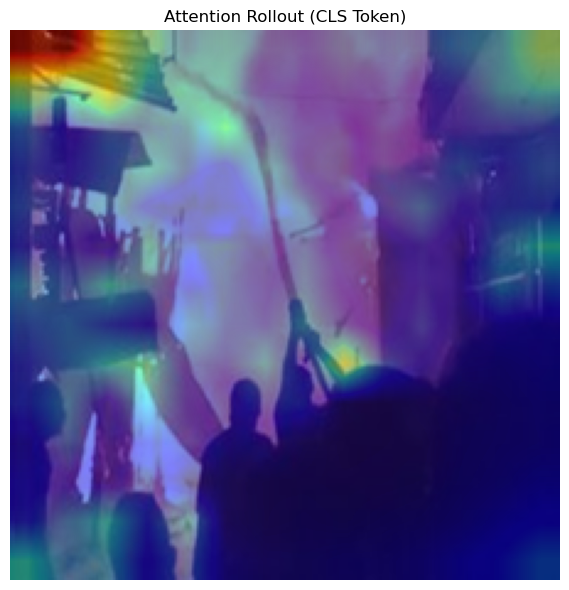

In [13]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from timm import create_model
import numpy as np
import cv2

# Set image path and model details
image_path = 'data/val/fire/0017.png'
model_path = 'vit_forest_fire.pth'
model_name = 'vit_tiny_patch16_224'

# Load model and set to evaluation mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model(model_name, pretrained=False, num_classes=2)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device).eval()

# Load and preprocess image
img = Image.open(image_path).convert("RGB")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
input_tensor = transform(img).unsqueeze(0).to(device)

# Hook function to extract attention weights
attn_weights = []

def get_attention_hook(module, input, output):
    try:
        x = input[0].detach().cpu()  # token embeddings
        B, N, C = x.shape
        qkv = module.qkv(x)
        qkv = qkv.reshape(B, N, 3, -1).permute(2, 0, 1, 3)
        q, k, _ = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * (1.0 / (q.shape[-1] ** 0.5))
        attn = attn.softmax(dim=-1)
        attn_weights.append(attn.cpu().detach())
    except Exception as e:
        print("Attention hook error:", e)

# Register hook on all attention layers
for blk in model.blocks:
    blk.attn.register_forward_hook(get_attention_hook)

# Forward pass to collect attention
attn_weights.clear()
with torch.no_grad():
    _ = model(input_tensor)

# Compute attention rollout from CLS token
def compute_rollout(attn_weights):
    result = torch.eye(attn_weights[0].size(-1)).to(device)
    for attn in attn_weights:
        attn = attn.squeeze(0)
        attn += torch.eye(attn.shape[0]).to(device)
        attn /= attn.sum(dim=-1, keepdim=True)
        result = attn @ result
    return result[0, 1:]

rollout = compute_rollout(attn_weights)
num_patches = rollout.shape[0]
side = int(num_patches ** 0.5)
rollout_map = rollout.reshape(side, side).cpu().numpy()
rollout_resized = cv2.resize(rollout_map, (224, 224))

# Visualize attention overlay
plt.figure(figsize=(6, 6))
plt.imshow(img.resize((224, 224)))
plt.imshow(rollout_resized, cmap='jet', alpha=0.5)
plt.title("Attention Rollout (CLS Token)")
plt.axis('off')
plt.tight_layout()
plt.show()

In [14]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from timm import create_model
import numpy as np
import cv2

# load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model('vit_tiny_patch16_224', pretrained=False, num_classes=2)
model.load_state_dict(torch.load('vit_forest_fire.pth', map_location=device))
model.to(device).eval()

# image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# load and preprocess image
def load_image(path):
    img = Image.open(path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0).to(device)
    return img, input_tensor

# extract attention from model
def extract_attention(input_tensor):
    attn_weights = []

    def get_attention_hook(module, input, output):
        x = input[0].detach()
        B, N, C = x.shape
        qkv = module.qkv(x)
        qkv = qkv.reshape(B, N, 3, -1).permute(2, 0, 1, 3)
        q, k, _ = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * (1.0 / (q.shape[-1] ** 0.5))
        attn = attn.softmax(dim=-1)
        attn_weights.append(attn.cpu().detach())

    hooks = []
    for blk in model.blocks[:6]:
        h = blk.attn.register_forward_hook(get_attention_hook)
        hooks.append(h)

    with torch.no_grad():
        model(input_tensor)

    for h in hooks:
        h.remove()

    return attn_weights

# compute attention rollout
def compute_rollout(attn_weights):
    result = torch.eye(attn_weights[0].size(-1))
    for attn in attn_weights:
        attn = attn.squeeze(0)
        attn += torch.eye(attn.shape[-1])
        attn /= attn.sum(dim=-1, keepdim=True)
        result = attn @ result
    return result[0, 1:]

# generate heatmap overlay
def generate_attention_overlay(img_pil, input_tensor):
    attn = extract_attention(input_tensor)
    rollout = compute_rollout(attn)
    num_patches = rollout.shape[0]
    side = int(num_patches ** 0.5)
    rollout_map = rollout.reshape(side, side).numpy()
    rollout_map -= rollout_map.min()
    rollout_map /= rollout_map.max()
    rollout_resized = cv2.resize(rollout_map, (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255 * rollout_resized), cv2.COLORMAP_JET)
    img_np = np.array(img_pil.resize((224, 224))).astype(np.uint8)
    overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)
    return overlay, rollout_resized

# predict class label
def predict_label(input_tensor):
    with torch.no_grad():
        output = model(input_tensor)
        pred = torch.argmax(output, dim=1).item()
        label = "Non-Fire"

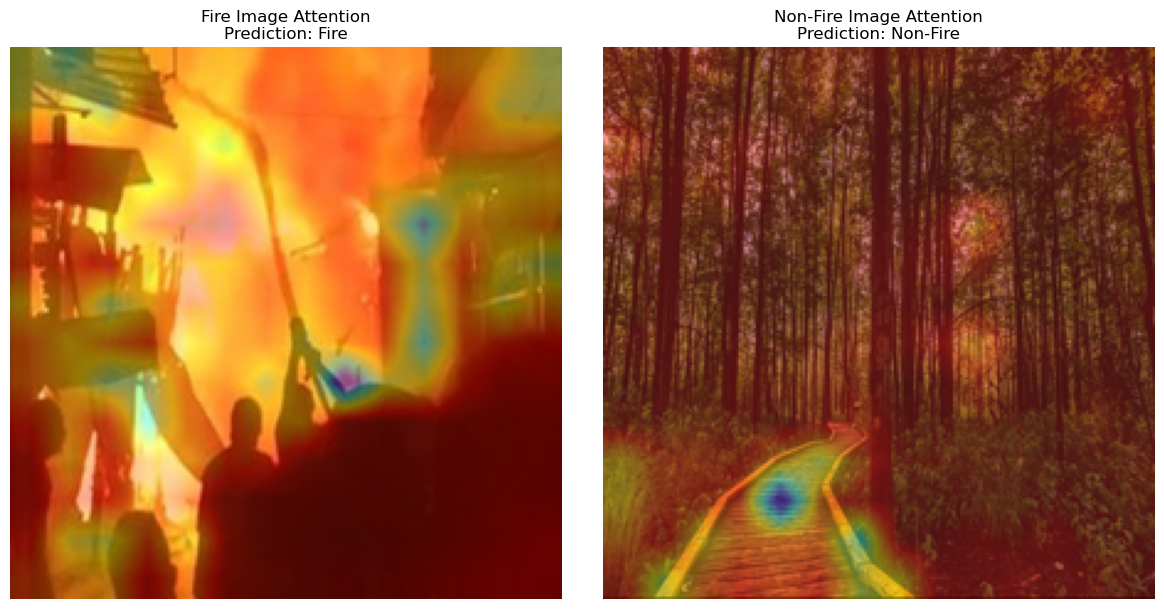

In [15]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from timm import create_model
import numpy as np
import cv2

# load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model('vit_tiny_patch16_224', pretrained=False, num_classes=2)
model.load_state_dict(torch.load('vit_forest_fire.pth', map_location=device))
model.to(device).eval()

# image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# load and preprocess image
def load_image(path):
    img = Image.open(path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0).to(device)
    return img, input_tensor

# extract attention from model
def extract_attention(input_tensor):
    attn_weights = []

    def get_attention_hook(module, input, output):
        x = input[0].detach()
        B, N, C = x.shape
        qkv = module.qkv(x)
        qkv = qkv.reshape(B, N, 3, -1).permute(2, 0, 1, 3)
        q, k, _ = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * (1.0 / (q.shape[-1] ** 0.5))
        attn = attn.softmax(dim=-1)
        attn_weights.append(attn.cpu().detach())

    hooks = []
    for blk in model.blocks[:6]:
        h = blk.attn.register_forward_hook(get_attention_hook)
        hooks.append(h)

    with torch.no_grad():
        model(input_tensor)

    for h in hooks:
        h.remove()

    return attn_weights

# compute attention rollout
def compute_rollout(attn_weights):
    result = torch.eye(attn_weights[0].size(-1))
    for attn in attn_weights:
        attn = attn.squeeze(0)
        attn += torch.eye(attn.shape[-1])
        attn /= attn.sum(dim=-1, keepdim=True)
        result = attn @ result
    return result[0, 1:]

# generate heatmap overlay
def generate_attention_overlay(img_pil, input_tensor):
    attn = extract_attention(input_tensor)
    rollout = compute_rollout(attn)
    num_patches = rollout.shape[0]
    side = int(num_patches ** 0.5)
    rollout_map = rollout.reshape(side, side).numpy()
    rollout_map -= rollout_map.min()
    rollout_map /= rollout_map.max()
    rollout_resized = cv2.resize(rollout_map, (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255 * rollout_resized), cv2.COLORMAP_JET)
    img_np = np.array(img_pil.resize((224, 224))).astype(np.uint8)
    overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)
    return overlay, rollout_resized

# predict class label
def predict_label(input_tensor):
    with torch.no_grad():
        output = model(input_tensor)
        pred = torch.argmax(output, dim=1).item()
        label = "Non-Fire" if pred == 1 else "Fire"
    return label

# compare fire and non-fire images
fire_img_path = 'data/val/fire/0017.png'
non_fire_img_path = 'data/val/nofire/0042.png'

fire_img, fire_tensor = load_image(fire_img_path)
non_fire_img, non_fire_tensor = load_image(non_fire_img_path)

fire_overlay, _ = generate_attention_overlay(fire_img, fire_tensor)
non_fire_overlay, _ = generate_attention_overlay(non_fire_img, non_fire_tensor)

fire_label = predict_label(fire_tensor)
non_fire_label = predict_label(non_fire_tensor)

# display images with attention overlay
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(fire_overlay)
plt.title(f"Fire Image Attention\nPrediction: {fire_label}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(non_fire_overlay)
plt.title(f"Non-Fire Image Attention\nPrediction: {non_fire_label}")
plt.axis('off')

plt.tight_layout()
plt.show()

Processing 0008.png ...


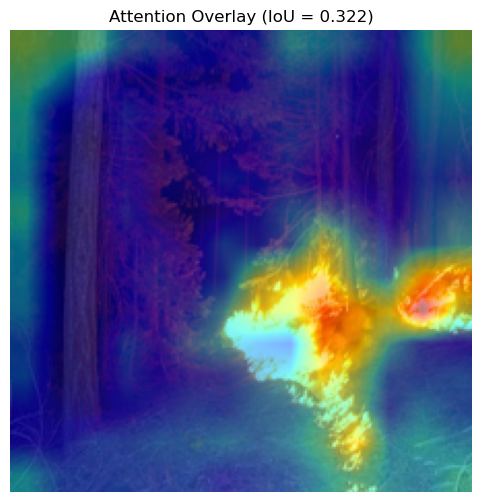

Processing 0017.png ...


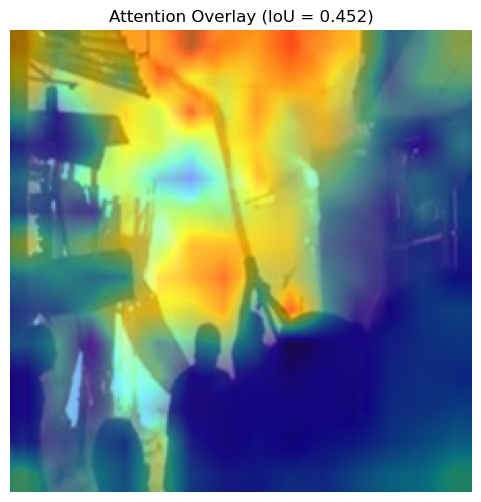

Processing 0051.png ...


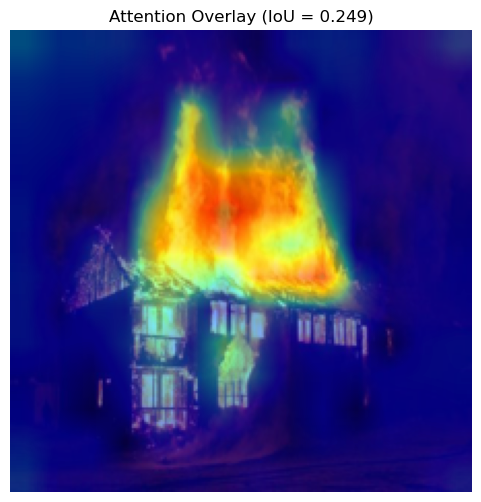

Processing 0086.png ...


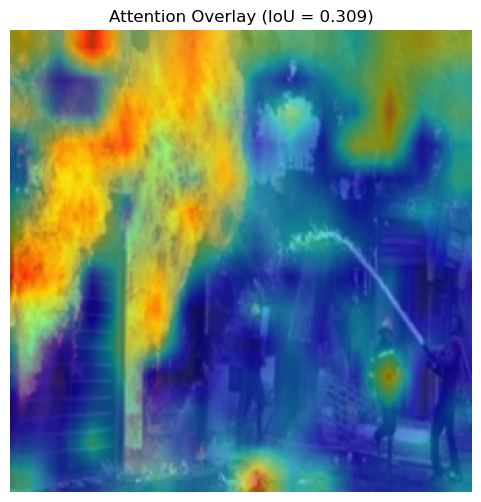

Processing 0103.png ...


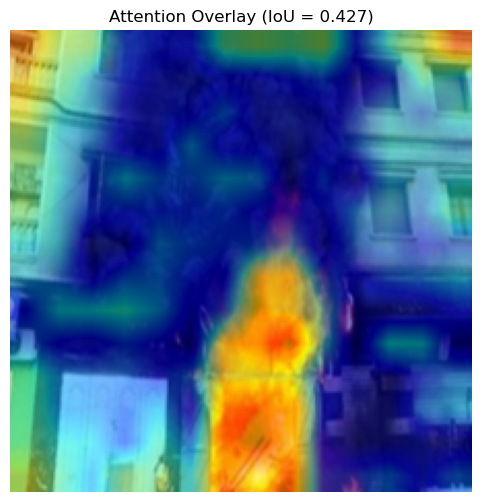


Average IoU over 5 images: 0.3517


In [16]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
from timm import create_model
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

# load Vision Transformer model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model('vit_tiny_patch16_224', pretrained=False, num_classes=2)
model.load_state_dict(torch.load('vit_forest_fire.pth', map_location=device))  # optionally add weights_only=True
model = model.to(device).eval()

# compute attention rollout from input image
def get_attention_rollout(input_tensor):
    attn_weights = []

    def hook_fn(module, input, output):
        x = input[0]
        B, N, C = x.shape
        qkv = module.qkv(x).reshape(B, N, 3, module.num_heads, C // module.num_heads)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * module.scale
        attn = attn.softmax(dim=-1)
        attn_weights.append(attn.detach())

    handles = [blk.attn.register_forward_hook(hook_fn) for blk in model.blocks]

    with torch.no_grad():
        _ = model(input_tensor)

    for h in handles:
        h.remove()

    if not attn_weights:
        raise RuntimeError("Attention weights not captured.")

    result = torch.eye(attn_weights[0].size(-1)).to(device)
    for attn in attn_weights:
        attn = attn.squeeze(0).mean(dim=0)
        attn += torch.eye(attn.size(0)).to(device)
        attn /= attn.sum(dim=-1, keepdim=True)
        result = attn @ result

    rollout = result[0, 1:].reshape(14, 14).cpu().numpy()
    return rollout

# evaluate attention vs ground-truth mask
def evaluate_attention(image_path, mask_path, threshold=0.6):
    img = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    input_tensor = transform(img).unsqueeze(0).to(device)

    rollout_map = get_attention_rollout(input_tensor)
    rollout_resized = cv2.resize(rollout_map, (224, 224))
    attn_norm = (rollout_resized - rollout_resized.min()) / (rollout_resized.max() - rollout_resized.min())
    attn_binary = attn_norm > threshold

    mask = Image.open(mask_path).convert("L").resize((224, 224))
    mask = np.array(mask) > 128

    intersection = np.logical_and(attn_binary, mask).sum()
    union = np.logical_or(attn_binary, mask).sum()
    iou = intersection / union if union != 0 else 0

    plt.figure(figsize=(6, 6))
    plt.imshow(img.resize((224, 224)))
    plt.imshow(attn_norm, cmap='jet', alpha=0.5)
    plt.title(f"Attention Overlay (IoU = {iou:.3f})")
    plt.axis('off')
    plt.show()

    return iou

# evaluate attention quality across all images
mask_folder = 'data/mask'
image_folder = 'data/val/fire'
all_ious = []

for mask_file in os.listdir(mask_folder):
    if not mask_file.endswith('_mask.png'):
        continue

    base_name = mask_file.replace('_mask.png', '.png')
    image_path = os.path.join(image_folder, base_name)
    mask_path = os.path.join(mask_folder, mask_file)

    if not os.path.exists(image_path):
        print(f"Image not found for {mask_file}")
        continue

    print(f"Processing {base_name} ...")
    try:
        iou = evaluate_attention(image_path, mask_path)
        all_ious.append(iou)
    except Exception as e:
        print(f"Error with {mask_file}: {e}")

if all_ious:
    print(f"\nAverage IoU over {len(all_ious)} images: {np.mean(all_ious):.4f}")
else:
    print("No valid IoUs computed.")

Attention-Based Explainability Evaluation
To evaluate whether the Vision Transformer (ViT) attends to relevant fire regions during classification, we conducted an attention rollout analysis. The resulting attention maps were compared against ground-truth fire masks annotated using polygon labels.

We computed the Intersection-over-Union (IoU) between the model's attention and the annotated fire region for each image. This metric, which we term the Fire Attention Faithfulness Score (FAFS), quantifies the degree to which the model focuses on the actual fire during inference.( to include in paper)

In [18]:
# Creating CNN baseline for comparison
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torchvision.models import ResNet18_Weights

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# define transforms for training and validation
transform = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

# load datasets
train_data = datasets.ImageFolder('data/train', transform=transform['train'])
val_data = datasets.ImageFolder('data/val', transform=transform['val'])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

# load pretrained ResNet18 and modify final layer
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()

    acc = correct / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}, Train Acc: {acc:.4f}")

# save model
torch.save(model.state_dict(), 'resnet18_fire.pth')

Epoch 1/10, Loss: 6.5661, Train Acc: 0.9612
Epoch 2/10, Loss: 1.1455, Train Acc: 0.9952
Epoch 3/10, Loss: 0.5448, Train Acc: 0.9981
Epoch 4/10, Loss: 0.3017, Train Acc: 0.9990
Epoch 5/10, Loss: 0.2466, Train Acc: 0.9990
Epoch 6/10, Loss: 0.1545, Train Acc: 1.0000
Epoch 7/10, Loss: 0.0723, Train Acc: 1.0000
Epoch 8/10, Loss: 0.0987, Train Acc: 1.0000
Epoch 9/10, Loss: 0.1612, Train Acc: 0.9995
Epoch 10/10, Loss: 0.1480, Train Acc: 0.9995


In [19]:
# Validation Evaluation for CNN
model.eval()
val_correct = 0
total = 0
class_correct = [0] * 2
class_total = [0] * 2

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)

        val_correct += (preds == labels).sum().item()
        total += labels.size(0)

        for i in range(len(labels)):
            label = labels[i].item()
            class_total[label] += 1
            class_correct[label] += (preds[i] == label).item()

overall_acc = val_correct / total
print(f"\nOverall Validation Accuracy: {overall_acc:.4f}")

# Per-class accuracy
class_names = val_data.classes  # typically ['fire', 'nofire']
for i in range(2):
    if class_total[i] == 0:
        continue
    acc = class_correct[i] / class_total[i]
    print(f"Accuracy for class '{class_names[i]}': {acc:.4f}")


Overall Validation Accuracy: 0.9955
Accuracy for class 'fire': 0.9920
Accuracy for class 'nofire': 1.0000


In [20]:
# ViT Training pipeline 
import os
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from timm import create_model
from sklearn.metrics import classification_report
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Define data directory
data_dir = "./data"  # should contain 'train', 'val', 'test' folders

# Define image transforms
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

transform_eval = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load datasets
train_data = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_train)
val_data   = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_eval)
test_data  = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform_eval)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=32, shuffle=False)

class_names = train_data.classes
print("Classes:", class_names)

# Load pretrained ViT model
model = create_model('vit_tiny_patch16_224', pretrained=True, num_classes=2)
model.to(device)

# Freeze backbone, only train classifier head initially
for param in model.parameters():
    param.requires_grad = False
for param in model.head.parameters():
    param.requires_grad = True

# Define loss, optimizer and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

# Training function
def train(model, loader):
    model.train()
    total_loss, correct = 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (outputs.argmax(dim=1) == labels).sum().item()
    accuracy = correct / len(loader.dataset)
    return total_loss / len(loader), accuracy

# Evaluation function
def evaluate(model, loader, title="Validation"):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu()
            all_preds.extend(preds)
            all_labels.extend(labels)
    print(f"\n{title} Results")
    print(classification_report(all_labels, all_preds, target_names=class_names))

# Train classifier head only
for epoch in range(10):
    loss, acc = train(model, train_loader)
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}, Train Acc: {acc:.4f}")
    evaluate(model, val_loader)
    scheduler.step()

# Unfreeze full model for fine-tuning
for param in model.parameters():
    param.requires_grad = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=3, gamma=0.5)

print("\nFine-tuning full model...")
for epoch in range(5):
    loss, acc = train(model, train_loader)
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}, Train Acc: {acc:.4f}")
    evaluate(model, val_loader)
    scheduler.step()

# Save the trained model
torch.save(model.state_dict(), 'vit_forest_fire_improved.pth')
print("\nModel saved as vit_forest_fire_improved.pth")

# Final evaluation on test set
evaluate(model, test_loader, title="Test")

Using device: cpu
Classes: ['fire', 'nofire']
Epoch 1, Loss: 0.3120, Train Acc: 0.8710

Validation Results
              precision    recall  f1-score   support

        fire       0.91      0.99      0.95       250
      nofire       0.99      0.87      0.92       191

    accuracy                           0.94       441
   macro avg       0.95      0.93      0.94       441
weighted avg       0.94      0.94      0.94       441

Epoch 2, Loss: 0.2257, Train Acc: 0.9180

Validation Results
              precision    recall  f1-score   support

        fire       0.95      0.99      0.97       250
      nofire       0.99      0.93      0.96       191

    accuracy                           0.96       441
   macro avg       0.97      0.96      0.96       441
weighted avg       0.96      0.96      0.96       441

Epoch 3, Loss: 0.1851, Train Acc: 0.9316

Validation Results
              precision    recall  f1-score   support

        fire       0.97      0.99      0.98       250
      no

In [21]:
from sklearn.metrics import classification_report, accuracy_score

# Evaluate model on given dataloader and return accuracy
def evaluate_accuracy(model, dataloader, class_names, title="Validation"):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    print(f"\n{title} Accuracy: {accuracy:.4f}")
    print(f"\n{title} Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    return accuracy

In [22]:
evaluate_accuracy(model, val_loader, class_names, title="Validation")


Validation Accuracy: 0.9977

Validation Classification Report:
              precision    recall  f1-score   support

        fire       1.00      1.00      1.00       250
      nofire       1.00      0.99      1.00       191

    accuracy                           1.00       441
   macro avg       1.00      1.00      1.00       441
weighted avg       1.00      1.00      1.00       441



0.9977324263038548

In [23]:
# Final test evaluation
evaluate_accuracy(model, test_loader, class_names, title="Test")


Test Accuracy: 0.9955

Test Classification Report:
              precision    recall  f1-score   support

        fire       0.99      1.00      1.00       252
      nofire       1.00      0.99      0.99       192

    accuracy                           1.00       444
   macro avg       1.00      0.99      1.00       444
weighted avg       1.00      1.00      1.00       444



0.9954954954954955